# Exploratory Data Analysis - Billboard Hot 100 & Spotify Track Data

## Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
charts = pd.read_csv('../data/raw/chart-data', index_col=0)
songs = pd.read_csv('../data/raw/unique-songs', index_col=0)

In [3]:
charts['Date'] =  pd.to_datetime(charts['Date'], format='%Y-%m-%d')
charts.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19


In [4]:
#remove poor matches, blank sp_id and duplicate sp_id - 155 rows lost (~3%)
songs['Date'] =  pd.to_datetime(songs['Date'], format='%Y-%m-%d')
songs = songs[songs.Match_Ratio > 50].dropna(axis=0, subset=['SP_id']).\
                        drop_duplicates(subset='SP_id',keep=False).reset_index(drop = True)

songs.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,...,-5.484,1.0,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8,Bad Habits,Ed Sheeran,100.0,...,-3.712,0.0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14,good 4 u,Olivia Rodrigo,100.0,...,-5.044,1.0,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1,Rumors (feat. Cardi B),Lizzo,100.0,...,-5.524,0.0,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19,Kiss Me More (feat. SZA),Doja Cat,100.0,...,-3.541,1.0,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


In [5]:
#cols_to_use = songs.columns.difference(charts.columns).to_list()
#cols_to_use = ['BB_Title', 'BB_Artist', 'Genres', 'Match_Ratio', 'SP_Artist', 'SP_Title', 'SP_id',\
#               'acousticness', 'danceability', 'duration_ms', s'energy', 'instrumentalness', 'key', 'liveness',\
#               'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

#merged = pd.merge(charts, songs[cols_to_use], how='inner', on=['BB_Title','BB_Artist'])\
#                                                    .sort_values(by='Date', ascending=False)

#merged.head()

## Billboard Chart EDA

In [6]:
charts['BB_Artist'].value_counts()

Drake                                                     676
Taylor Swift                                              581
The Weeknd                                                447
Luke Bryan                                                433
Imagine Dragons                                           422
                                                         ... 
Meek Mill Featuring Kodak Black                             1
Jazmine Sullivan Featuring H.E.R.                           1
DJ Khaled Featuring Travis Scott, Rick Ross & Big Sean      1
3OH!3                                                       1
Lil Wayne Featuring Snoop Dogg                              1
Name: BB_Artist, Length: 2368, dtype: int64

In [7]:
unique = charts.drop_duplicates(subset=['BB_Title','BB_Artist'])
#plot artist vs. count?

In [8]:
weeks_on_chart = charts.groupby(by=['BB_Title','BB_Artist']).max().sort_values(by='Weeks', ascending = False)
weeks_on_chart

#54 are 52+ weeks

,,Rank,Date,PeakPos,LastPos,Weeks
BB_Title,BB_Artist,,,,,
Blinding Lights,The Weeknd,72,2021-08-28,11,72,89
Radioactive,Imagine Dragons,98,2014-05-10,93,98,87
Sail,AWOLNATION,100,2014-03-22,84,100,79
Counting Stars,OneRepublic,80,2014-10-18,32,80,68
Party Rock Anthem,LMFAO Featuring Lauren Bennett & GoonRock,50,2012-07-21,1,50,68
...,...,...,...,...,...,...
Paid The Fine,Young Thug & Gunna Featuring Lil Baby & YTB Trench,77,2021-05-01,77,0,1
Southside,Lil Baby,79,2018-06-02,79,0,1
Booker T,Bad Bunny,78,2020-12-12,78,0,1


In [9]:
most_weeks = charts[((charts['BB_Title'] == 'Blinding Lights') & (charts['BB_Artist'] == 'The Weeknd'))|\
                        ((charts['BB_Title'] == 'Radioactive') & (charts['BB_Artist'] == 'Imagine Dragons'))|\
                        ((charts['BB_Title'] == 'Sail') & (charts['BB_Artist'] == 'AWOLNATION'))|\
                        ((charts['BB_Title'] == 'Counting Stars') & (charts['BB_Artist'] == 'OneRepublic'))]

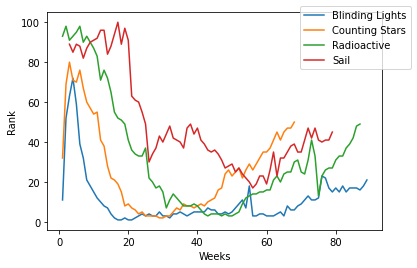

In [10]:
#week to week progression of top 4 longest lasting songs
ax = sns.lineplot(x="Weeks", y="Rank", hue="BB_Title", data=most_weeks)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [11]:
#songs that hit #1 on their first week
#charts[(charts['Weeks'] <= 1) & (charts['PeakPos'] <= 1)].sort_values(by='Date', ascending=False)\
#    .drop_duplicates(subset=['BB_Title','BB_Artist'])

In [12]:
#songs that were top 10 but didn't last on the charts for more than 3 weeks, watch out for recent ones
#weeks_on_chart[(weeks_on_chart.Weeks <= 3)&(weeks_on_chart.PeakPos <= 10)].sort_values(by='PeakPos')

In [13]:
by_year = charts.groupby(by=charts['Date'].dt.year).mean()

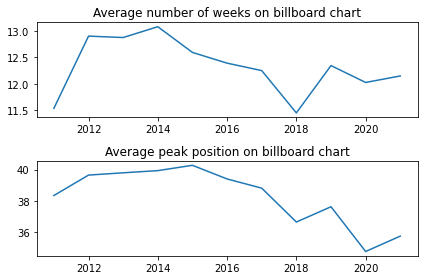

In [14]:
fig, ax = plt.subplots(2)

ax[0].plot(by_year.index.values, by_year['Weeks'])
ax[1].plot(by_year.index.values, by_year['PeakPos'])

ax[0].set_title('Average number of weeks on billboard chart')
ax[1].set_title('Average peak position on billboard chart')


fig.tight_layout()
plt.show()

## Unique Song Data EDA

In [15]:
#Find component with highest impact to peak pos
#scale the data

In [16]:
#52 songs have a null genre
#songs[songs['Genres'].isnull() == True]

songs['Genres'].value_counts()

contemporary country,country,country road                        173
contemporary country,country,country road,modern country rock    153
canadian hip hop,canadian pop,hip hop,rap,toronto rap            137
dance pop,pop                                                    128
pop                                                              115
                                                                ... 
glam metal,rock                                                    1
alabama indie,indie folk,indie rock,modern blues rock,rock         1
sertanejo,sertanejo pop,sertanejo universitario                    1
alabama rap                                                        1
hollywood,movie tunes                                              1
Name: Genres, Length: 764, dtype: int64

In [17]:
#songs.loc[songs['Genres'].str.contains('rap', na=False), 'Genres'] = 'rap'
#songs.loc[songs['Genres'].str.contains('pop', na=False), 'Genres'] = 'pop'

In [18]:
genre_list = [str(item) for item in list(set(songs['Genres'].to_list()))]
genre_list.sort(key=len)

#genre_list                                        

In [19]:
songs_numeric = ['SP_Title','SP_Artist', 'PeakPos', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',\
               'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

songs_scale = songs[songs_numeric].set_index(['SP_Title','SP_Artist','PeakPos'])
songs_scale_index = songs_scale.index
songs_scale_columns = songs_scale.columns

#songs_scale

In [20]:
songs_scale = scale(songs_scale)

songs_scaled_df = pd.DataFrame(songs_scale, columns=songs_scale_columns)
songs_scaled_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,-0.672479,-0.437575,-0.880129,0.677174,-0.129163,-1.156363,-0.586591,0.339803,0.767942,-0.657384,1.587273,0.10395,0.013799
1,-0.635280,1.035653,0.207436,1.467398,-0.128650,1.596798,1.358591,1.102645,-1.302182,-0.769496,0.098242,0.10395,0.532160
2,0.610871,-0.627669,-0.437218,0.083021,-0.129163,1.046166,-0.721487,0.529222,0.767942,0.220413,1.485522,0.10395,0.977125
3,-0.275839,1.164645,-0.501983,0.481103,-0.129163,-0.330415,1.761043,0.322583,-1.302182,-0.327691,-0.140331,0.10395,0.605556
4,0.178330,0.723356,-0.062813,0.302857,-0.126583,0.770850,-0.437535,1.176260,0.767942,-0.820985,-0.412483,0.10395,1.224837


In [21]:
#songs_scaled_df.mean()
#songs_scaled_df.std(ddof=0)

In [22]:
songs_pca = PCA().fit(songs_scale)

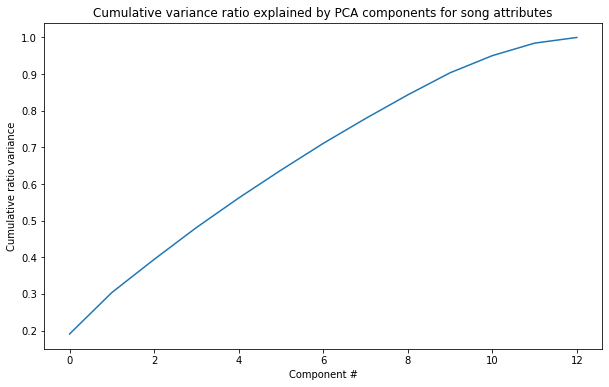

In [23]:
plt.subplots(figsize=(10, 6))
plt.plot(songs_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [24]:
songs_pca_x = songs_pca.transform(songs_scale)

In [25]:
songs_pca_x.shape

(4677, 13)

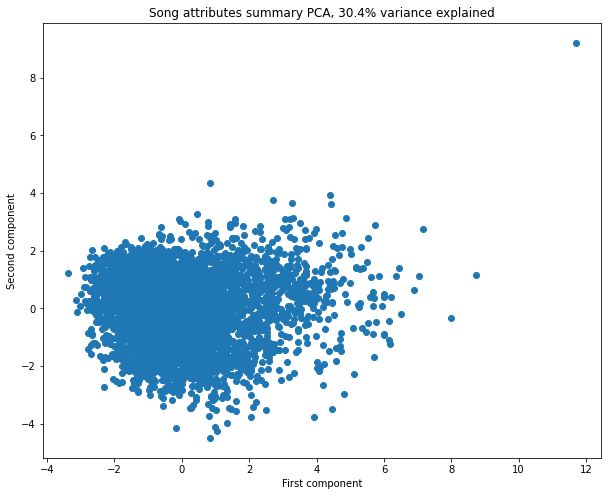

In [26]:
x = songs_pca_x[:, 0]
y = songs_pca_x[:, 1]
song = songs_scale_index
pc_var = 100 * songs_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Song attributes summary PCA, {pc_var:.1f}% variance explained')
plt.show()
#for s, x, y in zip(song, x, y):
#    plt.annotate(s, (x, y))

In [27]:
grouped_songs = songs.drop(columns=['Rank','LastPos','Match_Ratio']).groupby(pd.cut(songs["PeakPos"], \
                                                    np.arange(0, 100, 5))).mean()

grouped_songs

,PeakPos,Weeks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
PeakPos,,,,,,,,,,,,,,,
"(0, 5]",2.437870,32.970414,0.688675,0.652787,5.062130,-6.023109,0.621302,0.105144,0.172754,0.005493,0.181606,0.530584,122.212612,219079.426036,3.982249
"(5, 10]",7.817757,24.495327,0.667117,0.644472,4.775701,-6.403776,0.616822,0.127042,0.176959,0.011241,0.169426,0.478365,121.485729,218911.728972,4.000000
"(10, 15]",12.831169,19.549784,0.680437,0.631971,5.528139,-6.374766,0.614719,0.122990,0.182543,0.006241,0.185598,0.478336,121.300987,217260.722944,3.965368
"(15, 20]",17.889952,18.038278,0.653364,0.629278,5.540670,-6.244167,0.631579,0.119348,0.197712,0.005851,0.169430,0.444399,122.447144,217684.086124,3.971292
"(20, 25]",22.863905,15.272189,0.647521,0.656902,5.846154,-6.171154,0.597633,0.111899,0.208489,0.005141,0.185851,0.478756,121.369698,211055.278107,3.988166
"(25, 30]",27.919192,15.237374,0.644889,0.643924,5.161616,-6.466611,0.681818,0.125668,0.193267,0.009955,0.184954,0.471353,123.998884,218573.070707,3.989899
"(30, 35]",32.994382,13.011236,0.644107,0.667719,5.539326,-5.933938,0.679775,0.111842,0.193207,0.004862,0.182801,0.471292,124.145433,211228.691011,3.966292
"(35, 40]",38.041451,13.129534,0.659503,0.661772,5.233161,-5.945508,0.704663,0.118596,0.181713,0.010299,0.192569,0.477332,122.178420,218227.430052,3.974093
"(40, 45]",42.923077,12.171946,0.644113,0.661774,5.339367,-6.271529,0.660633,0.113967,0.196155,0.006120,0.181553,0.481915,123.798181,209404.411765,3.981900


In [28]:
grouped_scale = grouped_songs.drop(columns='PeakPos')
grouped_scale_index = grouped_scale.index
grouped_scale_columns = grouped_scale.columns

#grouped_scale

In [29]:
grouped_scale = scale(grouped_scale)

grouped_scaled_df = pd.DataFrame(grouped_scale, columns=grouped_scale_columns)
grouped_scaled_df.head()

,Weeks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2.688976,2.356615,0.191593,-0.512667,1.382032,-0.295696,-1.856303,-1.401537,-0.679975,0.061692,3.118408,-0.685967,1.021000,0.621384
1,1.619988,0.845313,-0.529879,-1.536585,-0.818390,-0.417112,0.089448,-1.117562,1.262224,-1.419334,0.231250,-1.188461,0.986678,1.591815
2,0.996191,1.779139,-1.614554,1.153205,-0.650702,-0.474138,-0.270595,-0.740390,-0.427250,0.547128,0.229643,-1.316173,0.648781,-0.301435
3,0.805541,-0.118852,-1.848261,1.198002,0.104218,-0.017125,-0.594181,0.284199,-0.559149,-1.418852,-1.646735,-0.523836,0.735427,0.022410
4,0.456646,-0.528469,0.548673,2.290036,0.526269,-0.937253,-1.256056,1.012170,-0.799098,0.577970,0.252824,-1.268673,-0.621233,0.944861


In [30]:
grouped_pca = PCA().fit(grouped_scale)

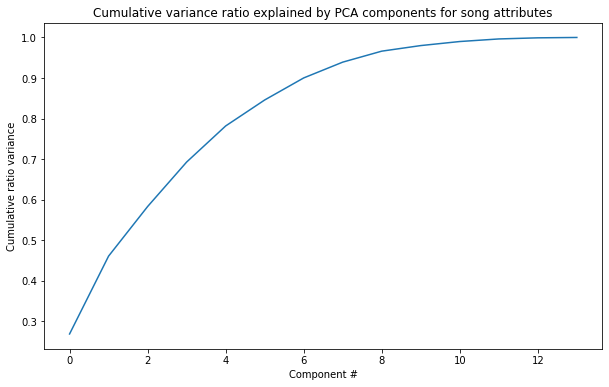

In [31]:
plt.subplots(figsize=(10, 6))
plt.plot(grouped_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [32]:
grouped_pca_x = grouped_pca.transform(grouped_scale)
grouped_pca_x.shape

(19, 14)

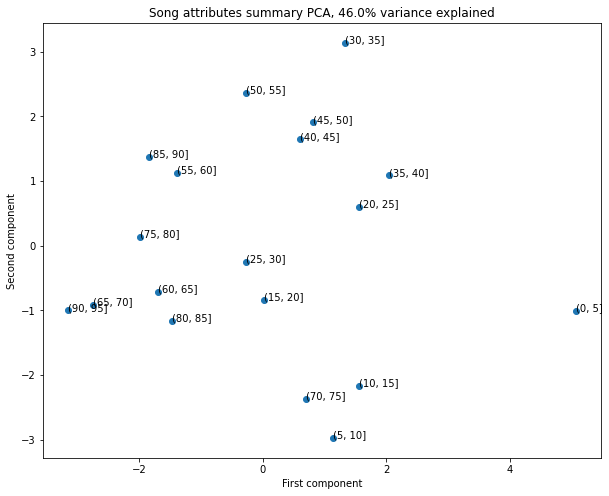

In [33]:
x = grouped_pca_x[:, 0]
y = grouped_pca_x[:, 1]
group_song = grouped_scale_index
pc_var = 100 * grouped_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Song attributes summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(group_song, x, y):
    plt.annotate(s, (x, y))

In [34]:
#corr plots for grouping
grouped_songs.corr()

#sns.pairplot(songs)
#plt.show()

,PeakPos,Weeks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
PeakPos,1.000000,-0.946286,-0.409207,0.045065,-0.318558,-0.339917,-0.263771,0.759956,0.432418,0.051601,0.024313,-0.441122,0.374384,-0.193707,-0.491892
Weeks,-0.946286,1.000000,0.534669,-0.072488,0.154614,0.331918,0.170885,-0.728832,-0.491239,-0.081648,-0.083098,0.590158,-0.380845,0.289878,0.481525
danceability,-0.409207,0.534669,1.000000,-0.225324,-0.016744,0.092025,-0.301369,-0.069699,-0.591827,0.338883,0.071999,0.485310,-0.611843,0.222970,0.185648
energy,0.045065,-0.072488,-0.225324,1.000000,0.082342,0.627606,0.295693,-0.253833,-0.223945,-0.168680,0.434833,0.353444,0.279102,-0.148177,-0.215458
key,-0.318558,0.154614,-0.016744,0.082342,1.000000,0.456962,-0.068601,-0.501262,0.092703,-0.370915,0.069504,0.033485,-0.395693,-0.071749,0.102164
loudness,-0.339917,0.331918,0.092025,0.627606,0.456962,1.000000,0.306048,-0.649751,-0.274620,-0.248003,0.093163,0.428277,-0.065840,0.029539,-0.112178
mode,-0.263771,0.170885,-0.301369,0.295693,-0.068601,0.306048,1.000000,-0.332985,-0.245917,-0.114971,0.054821,-0.061240,0.499468,-0.106001,0.126184
speechiness,0.759956,-0.728832,-0.069699,-0.253833,-0.501262,-0.649751,-0.332985,1.000000,0.246496,0.397222,-0.070479,-0.473360,0.177748,-0.055472,-0.353481
acousticness,0.432418,-0.491239,-0.591827,-0.223945,0.092703,-0.274620,-0.245917,0.246496,1.000000,0.006660,-0.253440,-0.300008,0.193019,-0.309115,-0.185852
instrumentalness,0.051601,-0.081648,0.338883,-0.168680,-0.370915,-0.248003,-0.114971,0.397222,0.006660,1.000000,-0.031610,-0.033587,-0.193117,-0.128866,0.078192


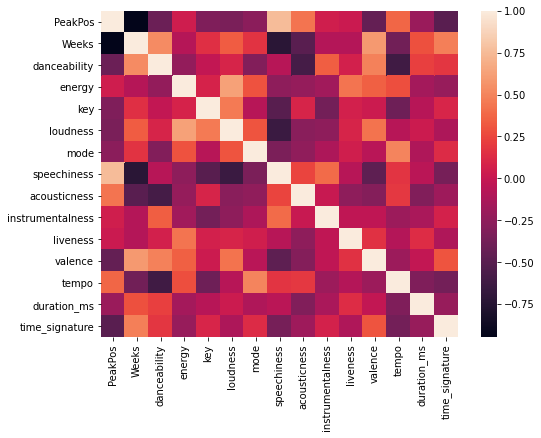

In [35]:
plt.subplots(figsize=(8,6))
sns.heatmap(grouped_songs.corr())
plt.show()

In [36]:
def scatterplots(columns, y, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y, data=grouped_songs, alpha=0.5)
        ax.set(xlabel=col, ylabel=y)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [37]:
features = [x for x in grouped_songs.columns]

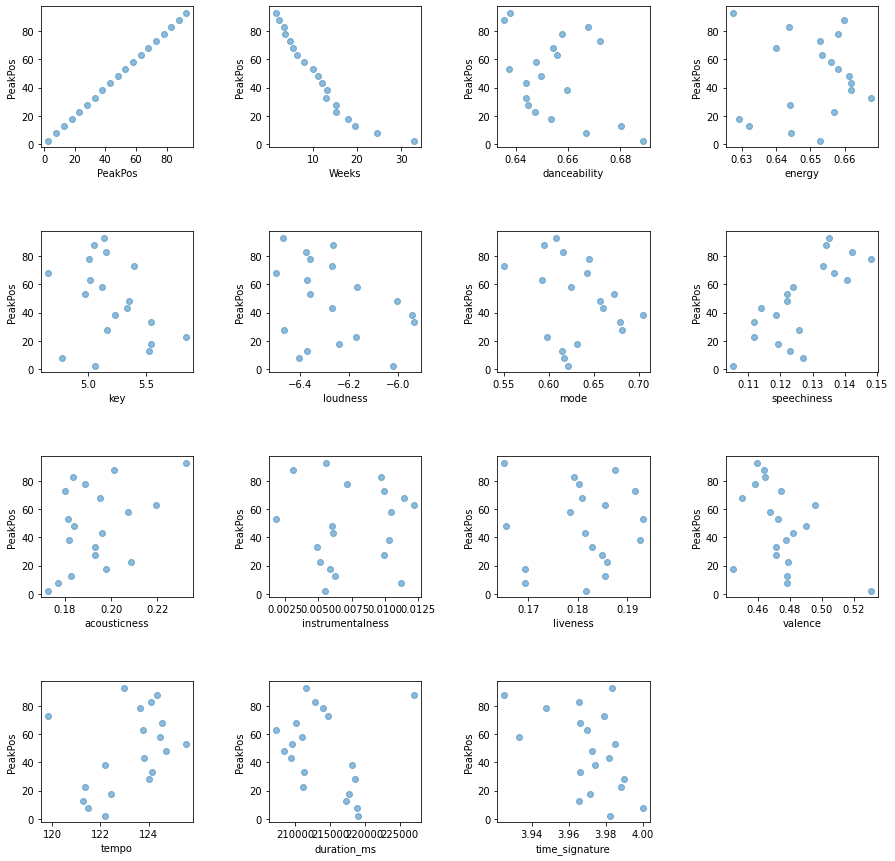

In [38]:
scatterplots(features, 'PeakPos', ncol=4, figsize=(15, 15))

In [39]:
#scatterplots(features, 'Weeks', ncol=4, figsize=(15, 15))

In [40]:
#look at top 10 grouping
top10_scale = songs.loc[songs['PeakPos'] <= 10, songs_numeric].groupby(by='PeakPos').mean()
top10_scale_index = top10_scale.index
top10_scale_columns = top10_scale.columns

top10_scale

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
PeakPos,,,,,,,,,,,,,
1,0.189055,0.695258,218055.772727,0.634750,0.001449,5.212121,0.171717,-6.226098,0.681818,0.100603,123.087735,3.984848,0.555083
2,0.159221,0.698224,229638.310345,0.636948,0.003415,4.844828,0.168114,-6.200534,0.534483,0.092612,117.017448,4.000000,0.550017
3,0.180565,0.678786,219391.785714,0.678571,0.004883,5.089286,0.202371,-5.890321,0.571429,0.123075,124.451411,3.982143,0.504030
4,0.165511,0.680865,214597.346154,0.673038,0.022128,4.519231,0.215275,-5.687442,0.692308,0.101381,122.692577,3.961538,0.496990
5,0.137067,0.677100,212536.500000,0.672850,0.001083,5.550000,0.160960,-5.718250,0.525000,0.118090,123.099425,3.975000,0.502410
6,0.150473,0.680464,209814.232143,0.662839,0.002936,4.875000,0.185005,-6.070536,0.625000,0.120470,120.621071,4.017857,0.495339
7,0.123986,0.695897,220760.461538,0.670436,0.007167,5.102564,0.193544,-5.742692,0.538462,0.155203,113.910231,4.000000,0.494744
8,0.194939,0.632286,228920.571429,0.601429,0.024086,3.938776,0.152012,-7.112510,0.653061,0.125529,126.430000,3.979592,0.441278
9,0.251449,0.682821,220153.714286,0.600393,0.004105,5.428571,0.189975,-7.089679,0.571429,0.109539,118.540357,3.964286,0.467236


In [41]:
top10_scale = scale(top10_scale)

top10_scale_df = pd.DataFrame(top10_scale, columns=top10_scale_columns)
top10_scale_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.431139,0.914924,-0.167162,-0.552062,-0.881908,0.610064,-0.232102,-0.069843,1.229181,-0.980510,0.397028,-0.202945,1.728625
1,-0.441124,1.067310,1.743956,-0.475847,-0.643232,-0.226064,-0.385033,-0.018104,-1.158368,-1.459548,-1.192853,0.554626,1.570140
2,0.182900,0.068800,0.053280,0.967249,-0.464938,0.330434,1.069104,0.609742,-0.559666,0.366631,0.754191,-0.338225,0.131293
3,-0.257233,0.175628,-0.737802,0.775419,1.629088,-0.967271,1.616823,1.020353,1.399162,-0.933886,0.293531,-1.368438,-0.088975
4,-1.088872,-0.017792,-1.077841,0.768885,-0.926406,1.379231,-0.688691,0.958001,-1.312034,0.067792,0.400090,-0.695366,0.080595


In [42]:
top10_pca = PCA().fit(top10_scale)

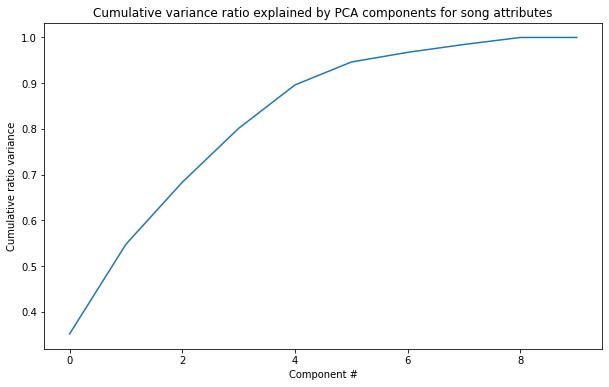

In [43]:
plt.subplots(figsize=(10, 6))
plt.plot(top10_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [44]:
top10_pca_x = top10_pca.transform(top10_scale)
top10_pca_x.shape

(10, 10)

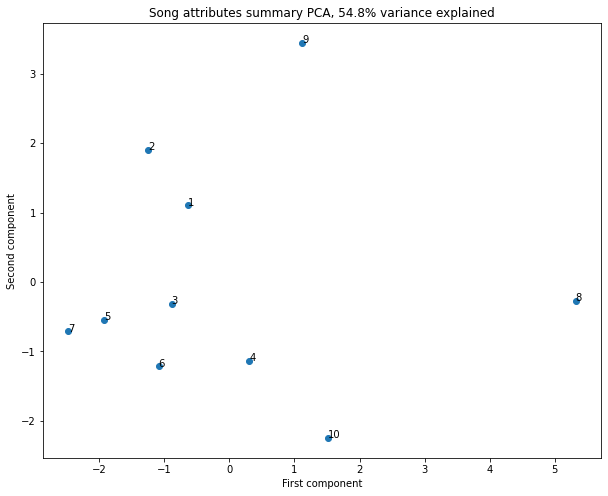

In [45]:
x = top10_pca_x[:, 0]
y = top10_pca_x[:, 1]
top10_song = top10_scale_index
pc_var = 100 * top10_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Song attributes summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(top10_song, x, y):
    plt.annotate(s, (x, y))

In [46]:
#songs.hist(figsize=(15,10))
#plt.subplots_adjust(hspace=0.5)

#sns.pairplot(grouped_songs)
#plt.show()

## TBD

In [47]:
#MERGED
#Seasonality (ie chart date vs. peak pos vs. attributes)
#components vs peak pos
#components vs # weeks
#group by top 10/top5

In [48]:
#songs.instrumentalness.value_counts().sort_values(ascending=False)
#songs.PeakPos.value_counts().sort_values(ascending=False)

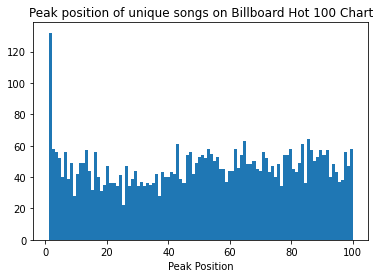

In [49]:
plt.hist(songs.PeakPos,bins=100)
plt.xlabel('Peak Position')
plt.title('Peak position of unique songs on Billboard Hot 100 Chart')
plt.show()

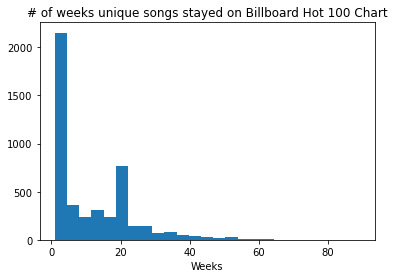

In [50]:
#songs.Weeks.value_counts().sort_values(ascending=False)
#better off finding the max values in the merged data
plt.hist(songs.Weeks,bins=25)
plt.xlabel('Weeks')
plt.title('# of weeks unique songs stayed on Billboard Hot 100 Chart')
plt.show()

In [51]:
#songs.corr()

#sns.pairplot(songs)
#plt.show()